# Sentiment Analysis for Stock Market Prediction #

Reference: https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178

### Imports and Packages ###

In [1]:
# For flair model
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# For text cleaning and preparation
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

# For dealing with dataframe
import pandas as pd

# For dealing with np array
import numpy as np

# For making request to API
import requests

# For calling yahoo finance to get stock price 
import pandas_datareader as pdr
import datetime as dt
from datetime import timedelta
import dateutil.parser as dparser

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.renderers.enable('default')
import seaborn as sns

# For dealing with system files and folders
import os
import json

# For model
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

2021-11-01 00:46:57,276 loading file /Users/aj/.flair/models/sentiment-en-mix-distillbert_4.pt


### Model Properties ###

In [2]:
# Twitter Properties
TWITTER_FILE_NAME = 'twitter_'
TWITTER_SEARCH_URI = 'https://api.twitter.com/1.1/search/tweets.json'  # Twitter API search URI
TWITTER_BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAF8pUQEAAAAAL7QXs9hTVl4Zq2GE%2FYhVQeJ9kyE%3DUaV8oJRddqkRSZfDXYqI7qS2lBnfRV8lj2S0K6BPJeg4pPfRQf'   # Token for twitter API
TWITTER_MAX_SENTIMENT = 200   # Maximum number of sentiments to fetch from twitter API

# Dataframe Properties
AUTHOR_NAME = 'Author_Name'
FOLLOWERS_COUNT = 'Followers_Count'
FRIENDS_COUNT = 'Friends_Count'
TEXT = 'Text'
RETWEET_COUNT = 'Retweet_Count'
CREATED_AT = 'Created_At'
SENTIMENT = 'Sentiment'
SENTIMENT_PROBABILITY = 'Sentiment_Probability'
STOCK_PRICE = 'Stock_Price'

# Stock Properties 
STOCK_NAME = 'tesla'    # Stock name to run model
STOCK_TICKER = 'TSLA'

## 1. Extract Raw Data ##
Calling Twitter API to get raw sentiments from users and saving to json file

In [3]:
data_path = './data/'
response_jsons = []
today_date = dt.datetime.now()
files = [file for file in os.listdir(data_path) if os.path.isfile(data_path + file) and not file.startswith('.')]

for i in range(7):
    request_date = (today_date - timedelta(days=i)).strftime("%Y-%m-%d")
    file_name = TWITTER_FILE_NAME + request_date
    
    if file_name not in files:  
        # Parmeters to pass to twitter API
        params = {
            'q': STOCK_NAME,
            'tweet_mode': 'extended',
            'lang': 'en',
            'count': TWITTER_MAX_SENTIMENT,
            'until': request_date
        }
        
        # Call twitter API
        response = requests.get(
            TWITTER_SEARCH_URI,
            params=params,
            headers={
                'authorization': 'Bearer '+ TWITTER_BEARER_TOKEN
        })
        
        # Output json to file
        with open((data_path + file_name + '.json'), 'w') as file:
            file.write(json.dumps(response.json()))
        
    

## 2. Dataset Creation ##

### I. Converting twitter response json from file to dataset ###

In [4]:
# Reading json file 
response_jsons = []
files = [file for file in os.listdir(data_path) if os.path.isfile(data_path + file) and not file.startswith('.')]

for file in sorted(files):
    with open(data_path + file) as json_file:
        json_data = json.load(json_file)
        response_jsons.append(json_data)

In [5]:
# Defining dataframe with features 
df = pd.DataFrame(columns=[
    AUTHOR_NAME, 
    FOLLOWERS_COUNT, 
    FRIENDS_COUNT, 
    TEXT, 
    RETWEET_COUNT, 
    CREATED_AT
])

In [6]:
# Converting twitter response json to dataset selecting required features
for response_json in response_jsons:
    for status in response_json['statuses']:    
        df = df.append({
            AUTHOR_NAME: status['user']['name'],
            FOLLOWERS_COUNT: status['user']['followers_count'], 
            FRIENDS_COUNT: status['user']['friends_count'],
            TEXT: status['full_text'],
            RETWEET_COUNT: status['retweet_count'],
            CREATED_AT: status['created_at']
        }, ignore_index=True)

In [7]:
df.head(5)

,Author_Name,Followers_Count,Friends_Count,Text,Retweet_Count,Created_At
0,Primero Amigo,35,146,RT @teslaunivrse: #cybertruck looks incredible...,222,Fri Oct 22 23:59:46 +0000 2021
1,Fitsum,76,415,"Tesla (TSLA) reaches new all-time high, surpas...",0,Fri Oct 22 23:59:46 +0000 2021
2,Chris Meyer,15,7,@MicroVision Hopefully #Microvision #MVIS will...,0,Fri Oct 22 23:59:40 +0000 2021
3,Lavdish,30,218,RT @jingkey_: jinki said a camera director who...,182,Fri Oct 22 23:59:40 +0000 2021
4,ʞooʞıɾ —,393,2760,RT @Jopromote: Hey Guys Amazing chance to win ...,960,Fri Oct 22 23:59:40 +0000 2021


### II. Creating Stock Price label by using yahoo finance module ###

In [8]:
# Creating dictionary of date and stock price for particular stock 
stock_price = pdr.get_data_yahoo(STOCK_TICKER, start = dt.datetime(2021,7,22), end = dt.datetime(2021,10,29))['Close']

In [9]:
# Function to format date to yyyy-MM-dd
def format_date(mydate):
    parsed_date = dparser.parse(mydate, fuzzy=True)
    date_time = dt.datetime(parsed_date.year, parsed_date.month, parsed_date.day)
    
    no_of_week = date_time.weekday()
    if no_of_week < 5:
        return str(parsed_date.year)+'-'+str(parsed_date.month)+'-'+str(parsed_date.day)
    elif no_of_week == 5:
        return str(parsed_date.year)+'-'+str(parsed_date.month)+'-'+str(parsed_date.day - 1)
    elif no_of_week == 6:
        return str(parsed_date.year)+'-'+str(parsed_date.month)+'-'+str(parsed_date.day - 2)

In [10]:
df[CREATED_AT] = pd.Series(map(format_date,df[CREATED_AT]))

In [11]:
df[STOCK_PRICE] = pd.Series([ stock_price[mydate] for mydate in df[CREATED_AT]])

## 3. Feature Engineering ##

### I. Applying text cleaning methods ###

In [12]:
# Function to clean text by applying several text cleaning methods
def clean_prepare_text(text):
    # 1. Clean the text - cleaning special character
    filtered_text = text.replace("\r", " ").replace("\n", " ").replace("  ", " ")

    # 2. Remove all the punctuations
    for punct_sign in list("?:!,;\""):
        filtered_text = filtered_text.replace(punct_sign, '')

    # 3. Convert to lowercase 
    filtered_text = filtered_text.lower()

    # 4. Remove stopwords
    filtered_text = " ".join([text for text in filtered_text.split(" ") if text not in stopwords.words('english')])

    # 5. Remove meaningles words 
    filtered_text = filtered_text.replace("\'ve", '').replace("\'s", '').replace("\'m", '').replace("\'t", '')

    # 6.a. Stemming
    filtered_text = " ".join([stemmer.stem(text) for text in filtered_text.split(" ")])

    # 6.b. lemmatization
    filtered_text = " ".join([lemmatizer.lemmatize(text) for text in filtered_text.split(" ")])

    return filtered_text


In [13]:
# Clean and Prepare text for further processing
df[TEXT] = [clean_prepare_text(text) for text in df[TEXT]]

### II. Creating Sentiment Feature by using pretrained 'flair' Model ###

In [14]:
sentiments = []
sentiment_probabilities = []

for text in df[TEXT]:
    sentence = flair.data.Sentence(text)
    sentiment_model.predict(sentence)
    
    probability = sentence.labels[0].score  # numerical value 0-1
    sentiment = sentence.labels[0].value    # 'POSITIVE' or 'NEGATIVE'
    
    sentiments.append(sentiment)
    sentiment_probabilities.append(probability)
    
df[SENTIMENT] = sentiments
df[SENTIMENT_PROBABILITY] = sentiment_probabilities

In [15]:
# Displaying top 5 record for visualizing
df.head(5)

,Author_Name,Followers_Count,Friends_Count,Text,Retweet_Count,Created_At,Stock_Price,Sentiment,Sentiment_Probability
0,Primero Amigo,35,146,rt @teslaunivrs #cybertruck look incredible. 😍...,222,2021-10-22,909.679993,POSITIVE,0.990210
1,Fitsum,76,415,tesla (tsla) reach new all-tim high surpass $9...,0,2021-10-22,909.679993,POSITIVE,0.960430
2,Chris Meyer,15,7,@microvis hope #microvis #mvi start lidar prod...,0,2021-10-22,909.679993,POSITIVE,0.928949
3,Lavdish,30,218,rt @jingkey_ jinki said camera director work i...,182,2021-10-22,909.679993,POSITIVE,0.837071
4,ʞooʞıɾ —,393,2760,rt @jopromot hey guy amaz chanc win 🤩👇 $67000 ...,960,2021-10-22,909.679993,POSITIVE,0.992259


### III. Encoding the categorical variable ###

In [16]:
def is_pos(sentiment):
    if sentiment=='POSITIVE':
        return 1
    else:
        return -1
df[SENTIMENT] = pd.Series([is_pos(sentiment) for sentiment in df[SENTIMENT]])

### IV. Exploratory Data Analysis ###

In [17]:
df.describe(include = 'all')

,Author_Name,Followers_Count,Friends_Count,Text,Retweet_Count,Created_At,Stock_Price,Sentiment,Sentiment_Probability
count,999,999.0,999.0,999,999.0,999,999.000000,999.000000,999.000000
unique,942,575.0,698.0,702,198.0,6,NaN,NaN,NaN
top,TSLA_bot,1.0,30.0,rt @elonmusk @drelidavid wfp describ twitter t...,0.0,2021-10-22,NaN,NaN,NaN
freq,6,20.0,10.0,32,355.0,300,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1022.868827,-0.013013,0.885020
std,NaN,NaN,NaN,NaN,NaN,NaN,81.631281,1.000416,0.146084
min,NaN,NaN,NaN,NaN,NaN,NaN,909.679993,-1.000000,0.501194
25%,NaN,NaN,NaN,NaN,NaN,NaN,909.679993,-1.000000,0.822042
50%,NaN,NaN,NaN,NaN,NaN,NaN,1024.859985,-1.000000,0.959670
75%,NaN,NaN,NaN,NaN,NaN,NaN,1114.000000,1.000000,0.994801


/Users/aj/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


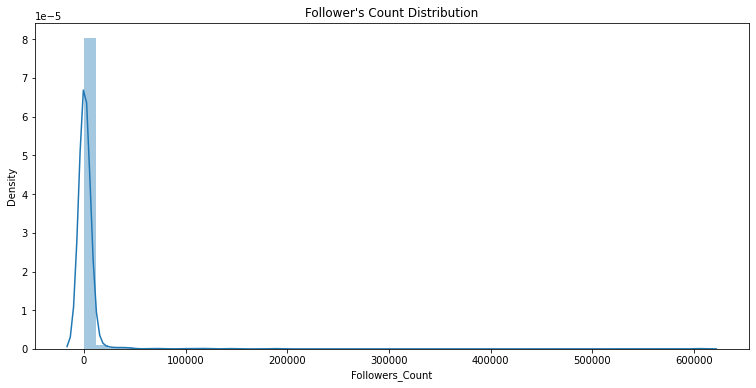

In [18]:
plt.figure(figsize=(12.8,6))
sns.distplot(df[FOLLOWERS_COUNT]).set_title('Follower\'s Count Distribution');

In [19]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X(SENTIMENT),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of tweets')),
    tooltip=[alt.Tooltip('count()', title='Number of tweets'), SENTIMENT],
    color=SENTIMENT

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of tweets in each sentiment",
)


alt.LayerChart(...)

## 4. Split data into train and test ##

In [20]:
train_index = 0.7 * df.shape[0]
X_train = df[:int(train_index)][[FOLLOWERS_COUNT, FRIENDS_COUNT, RETWEET_COUNT, SENTIMENT, SENTIMENT_PROBABILITY]]
y_train =  df[:int(train_index)][STOCK_PRICE]

X_test = df[int(train_index):][[FOLLOWERS_COUNT, FRIENDS_COUNT, RETWEET_COUNT, SENTIMENT, SENTIMENT_PROBABILITY]]
y_test =  df[int(train_index):][STOCK_PRICE]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(699, 5)
(699,)
(300, 5)
(300,)


## 5. Create, Train and Evaluate Model ##

### I. Linear Regression ###

In [21]:
model = LinearRegression()

In [22]:
model.fit(X_train,y_train)

LinearRegression()

In [23]:
y_pred = model.predict(X_test)

# Printout relevant metrics
print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))


Model Coefficients: [-2.13250635e-04  1.86972571e-03  3.19322243e-03  1.03948547e+00
  8.27548967e+01]
Mean Absolute Error: 119.69320812611048
Coefficient of Determination: 0.0


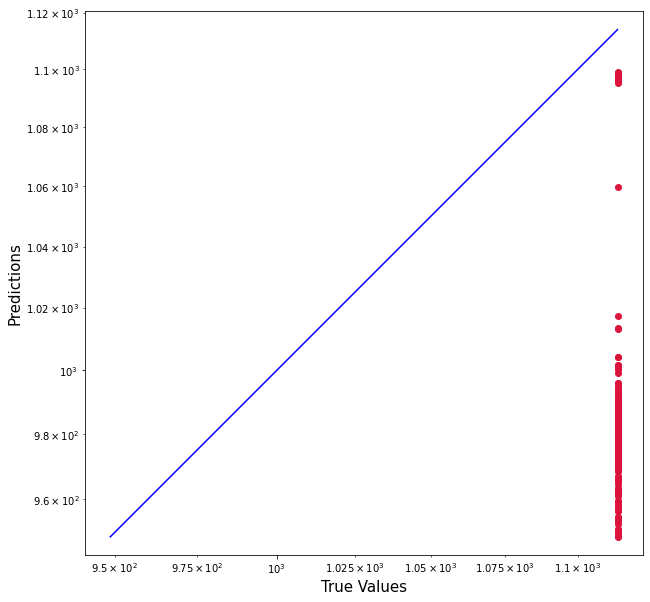

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### II. Stacked LSTM Model ###

In [25]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =np.asarray(X_train).astype(np.float32).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.asarray(X_test).astype(np.float32).reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
# Create Stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2021-11-01 00:48:09.336937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=10, verbose=1)

Epoch 1/25


2021-11-01 00:48:09.933356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


70/70 [==============================] - 5s 19ms/step - loss: 958911.8125 - val_loss: 1214531.2500
Epoch 2/25
70/70 [==============================] - 0s 6ms/step - loss: 944705.7500 - val_loss: 1205180.0000
Epoch 3/25
70/70 [==============================] - 0s 6ms/step - loss: 936822.5000 - val_loss: 1196549.2500
Epoch 4/25
70/70 [==============================] - 0s 6ms/step - loss: 929388.4375 - val_loss: 1188270.8750
Epoch 5/25
70/70 [==============================] - 0s 6ms/step - loss: 922182.7500 - val_loss: 1180174.3750
Epoch 6/25
70/70 [==============================] - 0s 6ms/step - loss: 915116.7500 - val_loss: 1172207.7500
Epoch 7/25
70/70 [==============================] - 0s 6ms/step - loss: 908152.5000 - val_loss: 1164332.0000
Epoch 8/25
70/70 [==============================] - 0s 6ms/step - loss: 901265.8750 - val_loss: 1156549.5000
Epoch 9/25
70/70 [==============================] - 0s 6ms/step - loss: 894449.0000 - val_loss: 1148829.2500
Epoch 10/25
70/70 [==========

In [29]:
y_pred = model.predict(X_test)

/Users/aj/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


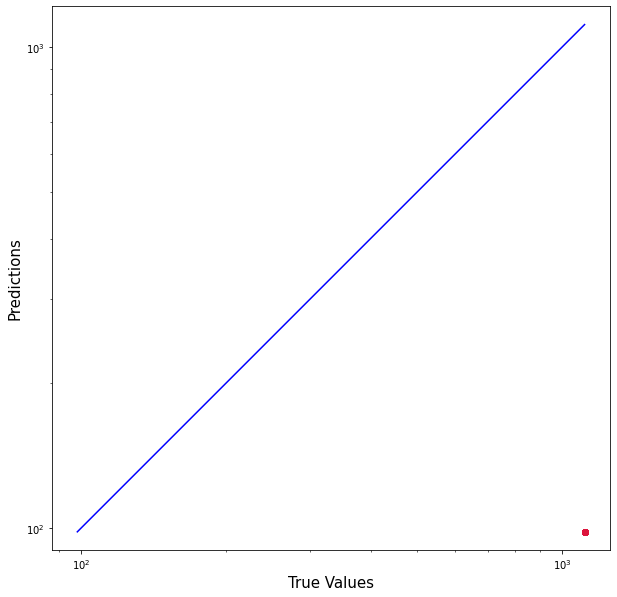

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## 6. Predict the Stock Price ##

## 7. Apply Abstractive Summarization ##